In [ ]:
# Transformers package uses Keras 2 objects, current version is Keras 3, packed in Tensorflow since version 2.16.
# Should you want tf.keras to stay on Keras 2 after upgrading to TensorFlow 2.16+, you can configure your TensorFlow installation so that tf.keras points to tf_keras. To achieve this:
# Make sure to install tf_keras. Note that TensorFlow does not install it by default.
# Export the environment variable TF_USE_LEGACY_KERAS=1.

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import os
import gdown
# import shutil
import numpy as np
import pandas as pd
import pathlib
import csv
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
# from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from google.colab import files

In [ ]:
from data_processing_utils import show_dirs_len, prepocess_to_crop
from models_processing_utils import add_files, sample_and_copy_files, generate_model_version_name, \
                                     binary_class_weights_2, initial_bias_calc_2, MetricsLogger, CustomCheckpoint,\
                                     ModelTraining, ModelEvaluating, ModelPredicting, make_model, plot_scores, plot_loss

## Завантаження даних

In [ ]:
# весь cropped датасет без аугментації
# https://drive.google.com/file/d/1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y/view?usp=sharing
file_id = "1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y"
url = f"https://drive.google.com/uc?id={file_id}"
output = "full_ds_croppedtr_no_augm.zip"

gdown.download(url, output, quiet=False)

!unzip -q full_ds_croppedtr_no_augm.zip

Downloading...
From (original): https://drive.google.com/uc?id=1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y
From (redirected): https://drive.google.com/uc?id=1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y&confirm=t&uuid=4df01975-e549-4ff1-acfe-43c731c17214
To: /content/full_ds_croppedtr_no_augm.zip
100%|██████████| 2.08G/2.08G [00:32<00:00, 64.4MB/s]


In [ ]:
# весь cropped датасет melanoma class з аугментацією 1:5
# https://drive.google.com/file/d/1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu/view?usp=sharing
file_id = "1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu"
url = f"https://drive.google.com/uc?id={file_id}"
output = "melanoma_augmented_cropped5v2.zip"

gdown.download(url, output, quiet=False)
!unzip -q melanoma_augmented_cropped5v2.zip

Downloading...
From (original): https://drive.google.com/uc?id=1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu
From (redirected): https://drive.google.com/uc?id=1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu&confirm=t&uuid=5c6af101-47f3-4835-a5b0-7459b31de716
To: /content/melanoma_augmented_cropped5v2.zip
100%|██████████| 156M/156M [00:03<00:00, 42.6MB/s]


In [ ]:
# додати аугментовані файли у датасет (якщо не використовується додаткова аугментація, а тільки version2)
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/melanoma_augmented_cropped5v2")
add_files(source_dir, dest_dir)

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

### Доповнення додатковою аугментацією

In [ ]:
# version3 аугментації (+ аугментація негативного класу)
# https://drive.google.com/file/d/1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja/view?usp=sharing

file_id = "1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja"
url = f"https://drive.google.com/uc?id={file_id}"
output = "augmented_cropped5v3.zip"

gdown.download(url, output, quiet=False)
!unzip -q augmented_cropped5v3.zip

Downloading...
From (original): https://drive.google.com/uc?id=1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja
From (redirected): https://drive.google.com/uc?id=1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja&confirm=t&uuid=936e4b94-37a5-48ba-8af1-82c1a17bcf21
To: /content/augmented_cropped5v3.zip
100%|██████████| 546M/546M [00:09<00:00, 56.4MB/s]


In [ ]:
# додати аугментовані дані в клас other
source_dir = pathlib.Path("/content/augmented/train/other")
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/other")
add_files(source_dir, dest_dir)

In [ ]:
# додати аугментовані дані класу melanoma v2
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/melanoma_augmented_cropped5v2")
# source_dir = pathlib.Path("/content/augmented_cropped5v3/augmented/train/melanoma")
add_files(source_dir, dest_dir)

In [ ]:
# відібрати частину аугментованих даних v3, класу меланома та домішати з заміною v2
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/augmented/train/melanoma")
sample_and_copy_files(source_dir, dest_dir)

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
validation: 2
validation/other: 1599
validation/melanoma: 1018
train: 2
train/other: 102562
train/melanoma: 24450
test: 2
test/other: 17549
test/melanoma: 1587


In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 1599
validation/melanoma: 1018
train: 2
train/other: 51281
train/melanoma: 4075


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 19136 files belonging to 2 classes.


## Parameters

In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
LEARNING_RATE = 2e-4

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

## Dataset

In [ ]:
# if full train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 127012 files belonging to 2 classes.
Found 2617 files belonging to 2 classes.
Found 19136 files belonging to 2 classes.


In [ ]:
# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### при дисбалансі класів

In [ ]:
count_1 = len(os.listdir(data_dir / "train/melanoma"))
count_0 = len(os.listdir(data_dir / "train/other"))

In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.62
Weight for class 1: 2.60


In [ ]:
# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

initial_bias: -1.4338372778413724


## Model

In [ ]:
MODEL_NAME = f'VIT-{VERSION}'

In [ ]:
!pip install transformers

In [ ]:
from transformers import TFViTModel, ViTConfig  #,AutoImageProcessor

In [ ]:
# This model is also a keras.Model subclass. Use it as a regular TF 2.0 Keras Model and refer to the TF 2.0 documentation for all matter related to general usage and behavior.
# "DunnBC22/vit-base-patch16-224-in21k_brain_tumor_diagnosis"

In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class ExtractCLSToken(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, 0, :]

    def get_config(self):
        base_config = super().get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
@register_keras_serializable()
class NormalizeMinus1To1(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, img):
        return (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2.0

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
model_id = "DunnBC22/vit-base-patch16-224-in21k_brain_tumor_diagnosis"

# Нормалізація [-1, 1], зміна розміру
resize_rescale_for_HF_VIT = tf.keras.Sequential([
  layers.Resizing(224, 224),
  NormalizeMinus1To1(),
  layers.Permute((3,1,2)),
], name="resize_rescale_for_HF_VIT")

In [ ]:
# processor = AutoImageProcessor.from_pretrained(model_id)
config = ViTConfig.from_pretrained(model_id)
# config.output_attentions = True
base_model = TFViTModel.from_pretrained(model_id, config=config, from_pt=True)

def vit_classifier(image_size=IM_SIZE, vit_model=base_model):
    inputs = tf.keras.Input(shape=(image_size, image_size, 3))
    preprocessed = resize_rescale_for_HF_VIT(inputs)
    print(f'Preprocessed layer: {preprocessed}')

    # Вихід ViT: тільки CLS токен (позиція [0]) як глобальне представлення зображення
    vit_outputs = vit_model(preprocessed, training=True)  # for fine-tuning
    cls_token = ExtractCLSToken(name='extract_cls_token')(vit_outputs.last_hidden_state)

    # Классифікатор після CLS токена
    x = layers.Dense(128, activation="relu")(cls_token)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation="sigmoid", name="pred")(x)

    model = Model(inputs=inputs, outputs=output)
    return model

vit_model = vit_classifier(vit_model=base_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessed layer: KerasTensor(type_spec=TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), name='resize_rescale_for_HF_VIT/permute/transpose:0', description="created by layer 'resize_rescale_for_HF_VIT'")


### Transfer learning

In [ ]:
model = make_model(learning_rate=LEARNING_RATE,
                   loss_func=tf.keras.losses.BinaryCrossentropy(),
                   metrics=METRICS,
                   model=vit_model,
                   output_bias=initial_bias)

In [ ]:
#for feature extraction
base_model.trainable = False

In [ ]:
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 resize_rescale_for_HF_VIT   (None, 3, 224, 224)       0         Y          
 (Sequential)                                                               
                                                                            
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPo   8638924   N          
                             oling(last_hidden_state   8                    
                             =(None, 197, 768),                             
                              pooler_output=(None, 7                        
                             68),                                           
                              hidden_states=None, at         

In [ ]:
labels = ['tl-', 'ft-']
label = labels[0]
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=3),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
]

epochs=5

In [ ]:
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
callbacks=callbacks_list,
class_weight=class_weights
)

Epoch 1/5


3970/3970 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.8753 - precision: 0.6348 - recall: 0.8295 - tp: 20282.0000 - fp: 11669.0000 - tn: 90893.0000 - fn: 4168.0000 - auc: 0.9387 - prc: 0.8538

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


3970/3970 [==============================] - 4954s 1s/step - loss: 0.3108 - accuracy: 0.8753 - precision: 0.6348 - recall: 0.8295 - tp: 20282.0000 - fp: 11669.0000 - tn: 90893.0000 - fn: 4168.0000 - auc: 0.9387 - prc: 0.8538 - val_loss: 0.3997 - val_accuracy: 0.8181 - val_precision: 0.8018 - val_recall: 0.7073 - val_tp: 720.0000 - val_fp: 178.0000 - val_tn: 1421.0000 - val_fn: 298.0000 - val_auc: 0.9038 - val_prc: 0.8499
Epoch 2/5
3970/3970 [==============================] - 4905s 1s/step - loss: 0.2687 - accuracy: 0.8900 - precision: 0.6647 - recall: 0.8644 - tp: 21134.0000 - fp: 10659.0000 - tn: 91903.0000 - fn: 3316.0000 - auc: 0.9548 - prc: 0.8839 - val_loss: 0.4040 - val_accuracy: 0.8284 - val_precision: 0.8729 - val_recall: 0.6542 - val_tp: 666.0000 - val_fp: 97.0000 - val_tn: 1502.0000 - val_fn: 352.0000 - val_auc: 0.9156 - val_prc: 0.8757
Epoch 3/5
3970/3970 [==============================] - 4951s 1s/step - loss: 0.2405 - accuracy: 0.8994 - precision: 0.6847 - recall: 0.8853 -

In [ ]:
model.save("tl-VIT-05-04-07.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('tl-VIT-05-04-07', save_format='tf')

In [ ]:
files.download(f'/content/{label}{MODEL_NAME}.keras')
files.download(f'/content/{label}{MODEL_NAME}.h5')
files.download(f'/content/{label}{MODEL_NAME}') #SavedModel format

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save_weights("tl-VIT-05-04-07.weights.h5")

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


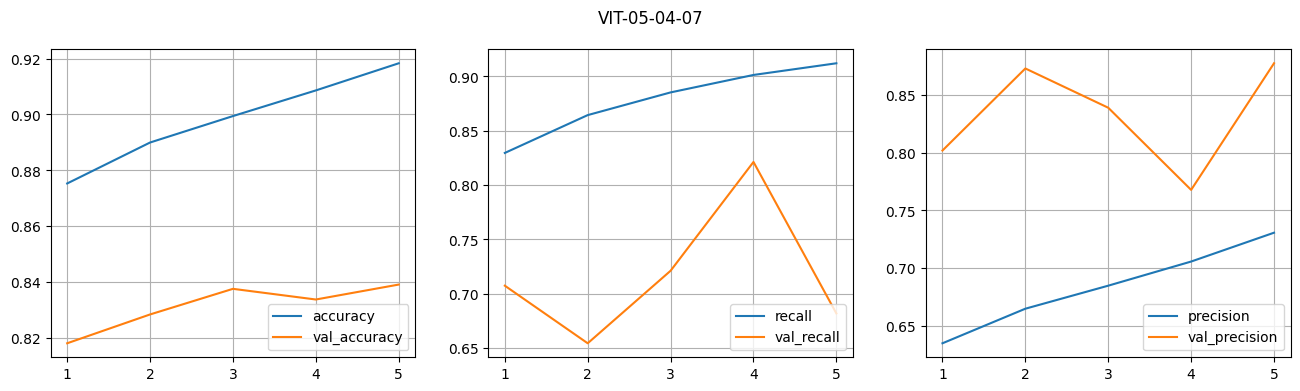

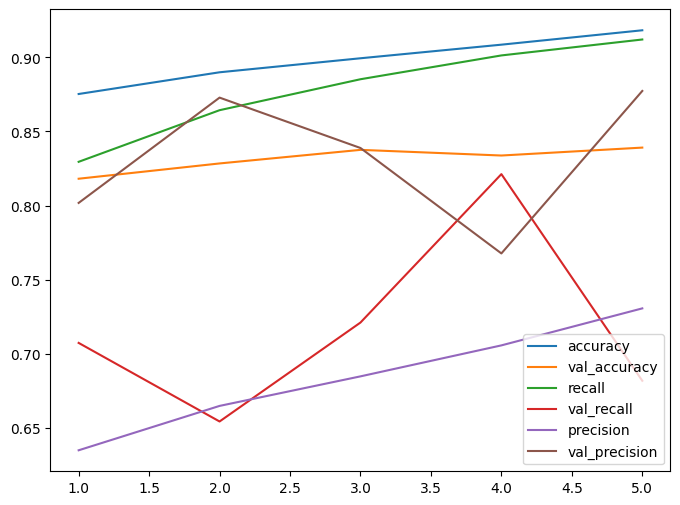

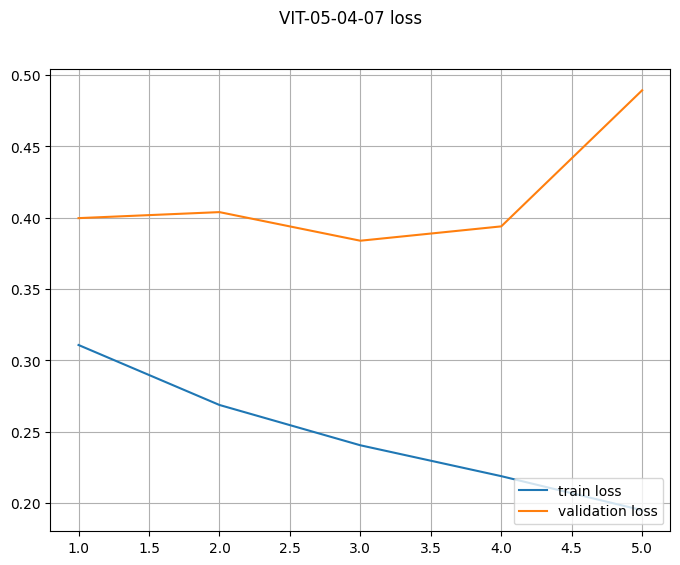

In [ ]:
df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

plot_scores(df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

In [ ]:
ModelEvaluating(test_ds,
                model, model_name='tl-' + MODEL_NAME,
                metrics=METRICS)

598/598 [==============================] - 263s 438ms/step - loss: 0.2583 - accuracy: 0.9127 - precision: 0.4775 - recall: 0.5539 - tp: 879.0000 - fp: 962.0000 - tn: 16587.0000 - fn: 708.0000 - auc: 0.8521 - prc: 0.5329
loss :  0.2583472728729248
accuracy :  0.9127299189567566
precision :  0.4774579107761383
recall :  0.553875207901001
tp :  879.0
fp :  962.0
tn :  16587.0
fn :  708.0
auc :  0.8521338105201721
prc :  0.5329275131225586
f1_beta :  0.5366955477823506


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0.2583472728729248,
 0.9127299189567566,
 0.4774579107761383,
 0.553875207901001,
 879.0,
 962.0,
 16587.0,
 708.0,
 0.8521338105201721,
 0.5329275131225586,
 0.5366955477823506]

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=(256, 256),
  batch_size=BATCH_SIZE,
  shuffle=False)

Found 19136 files belonging to 1 classes.


              precision    recall  f1-score   support

           0       0.96      0.95      0.95     17549
           1       0.48      0.55      0.51      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.75      0.73     19136
weighted avg       0.92      0.91      0.92     19136

(0.9191224798330292, 0.9127299331103679, 0.9138216194430772, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

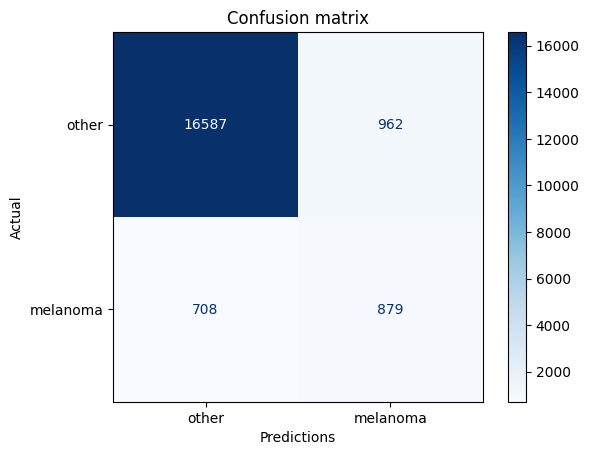

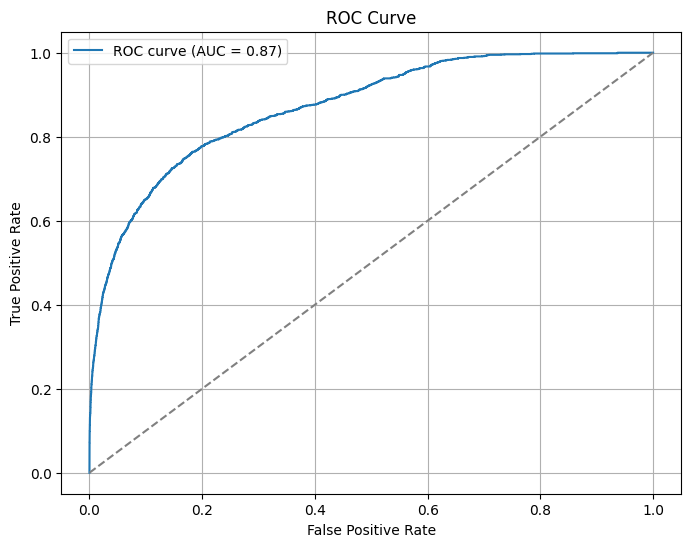

In [ ]:
predictions_df = ModelPredicting(test_dataset, model, model_name='tl-' + MODEL_NAME)

## Fine tuning

In [ ]:
# https://drive.google.com/file/d/1_5_K0FhKtyAQ-XIMoJeqcP0heEqNLCPW/view?usp=sharing
file_id = "1_5_K0FhKtyAQ-XIMoJeqcP0heEqNLCPW"
url = f"https://drive.google.com/uc?id={file_id}"
output = "tl-VIT-05-04-07.keras"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_5_K0FhKtyAQ-XIMoJeqcP0heEqNLCPW
From (redirected): https://drive.google.com/uc?id=1_5_K0FhKtyAQ-XIMoJeqcP0heEqNLCPW&confirm=t&uuid=63db1167-196e-49d3-9cb8-6c687af295e7
To: /content/tl-VIT-05-04-07.keras
100%|██████████| 1.04G/1.04G [00:18<00:00, 57.2MB/s]


'tl-VIT-05-04-07.keras'

In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class ExtractCLSToken(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, 0, :]

    def get_config(self):
        base_config = super().get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


@register_keras_serializable()
class NormalizeMinus1To1(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, img):
        return (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2.0

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
# Нормалізація [-1, 1], зміна розміру
resize_rescale_for_HF_VIT = tf.keras.Sequential([
  layers.Resizing(224, 224),
  NormalizeMinus1To1(),
  layers.Permute((3,1,2)),
], name="resize_rescale_for_HF_VIT")

In [ ]:
custom_objects = {
    "ExtractCLSToken": ExtractCLSToken,
    "resize_rescale_for_HF_VIT": resize_rescale_for_HF_VIT,
    "NormalizeMinus1To1": NormalizeMinus1To1,
    "TFViTModel": TFViTModel
}

In [ ]:
# model_path = f'/content/tl-VIT-05-04-07.h5'
# tl_model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [ ]:
model_path = f'/content/tl-VIT-05-04-07.keras'
backbone_model = keras.models.load_model(model_path, custom_objects=custom_objects)
backbone_model.summary()

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resize_rescale_for_HF_VIT   (None, 3, 224, 224)       0         
 (Sequential)                                                    
                                                                 
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                             

In [ ]:
backbone_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
backbone_model.trainable = True

In [ ]:
MODEL_NAME = 'ft-VIT-05-04-07'

In [ ]:
# ! class_weights, METRICS

MODEL_NAME = 'ft-VIT-05-04-07'
IM_SIZE = 256
BATCH_SIZE = 16
# VERSION = generate_model_version_name()
LEARNING_RATE = 3e-5

In [ ]:
count_1 = len(os.listdir(data_dir / "train/melanoma"))
count_0 = len(os.listdir(data_dir / "train/other"))

weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.62
Weight for class 1: 2.60


In [ ]:
# from tensorflow.keras.optimizers import Adam

# AdamW через TensorFlow

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=7939,
    decay_rate=0.95
)

optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule, weight_decay=0.01)
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=2),
                  ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True)]

epochs=5

In [ ]:
# from models_processing_utils_ import ModelTraining

In [ ]:
ModelTraining(train_ds, val_ds,
              backbone_model, model_name=MODEL_NAME, optimizer=optimizer,
              metrics=METRICS, output_bias=None,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)

ft-VIT-05-04-07
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 resize_rescale_for_HF_VIT   (None, 3, 224, 224)       0         Y          
 (Sequential)                                                               
                                                                            
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPo   8638924   Y          
                             oling(last_hidden_state   8                    
                             =(None, 197, 768),                             
                              pooler_output=(None, 7                        
                             68),                                           
                              hidden_states=N

7939/7939 [==============================] - 5446s 680ms/step - loss: 0.1745 - accuracy: 0.9300 - precision: 0.7638 - recall: 0.9210 - tp: 22518.0000 - fp: 6964.0000 - tn: 95598.0000 - fn: 1932.0000 - auc: 0.9812 - prc: 0.9454 - val_loss: 0.4913 - val_accuracy: 0.8391 - val_precision: 0.9117 - val_recall: 0.6493 - val_tp: 661.0000 - val_fp: 64.0000 - val_tn: 1535.0000 - val_fn: 357.0000 - val_auc: 0.9237 - val_prc: 0.9050
Epoch 2/5
7939/7939 [==============================] - 5390s 679ms/step - loss: 0.1071 - accuracy: 0.9568 - precision: 0.8398 - recall: 0.9587 - tp: 23440.0000 - fp: 4471.0000 - tn: 98091.0000 - fn: 1010.0000 - auc: 0.9927 - prc: 0.9751 - val_loss: 0.7018 - val_accuracy: 0.8376 - val_precision: 0.9316 - val_recall: 0.6287 - val_tp: 640.0000 - val_fp: 47.0000 - val_tn: 1552.0000 - val_fn: 378.0000 - val_auc: 0.8962 - val_prc: 0.8903
Epoch 3/5
7939/7939 [==============================] - 5385s 678ms/step - loss: 0.0599 - accuracy: 0.9766 - precision: 0.9056 - recall: 0.

KeyboardInterrupt: 

In [ ]:
model_path2 = '/content/ft-VIT-05-04-07.keras'
ft_model = keras.models.load_model(model_path2, custom_objects=custom_objects)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
ModelEvaluating(test_ds,
                ft_model, model_name=MODEL_NAME,
                metrics=METRICS)

1196/1196 [==============================] - 288s 237ms/step - loss: 0.2459 - accuracy: 0.9265 - precision: 0.5635 - recall: 0.5035 - tp: 799.0000 - fp: 619.0000 - tn: 16930.0000 - fn: 788.0000 - auc: 0.8614 - prc: 0.5532
loss :  0.24587540328502655
accuracy :  0.9264736771583557
precision :  0.563469648361206
recall :  0.5034656524658203
tp :  799.0
fp :  619.0
tn :  16930.0
fn :  788.0
auc :  0.8614433407783508
prc :  0.5532389879226685
f1_beta :  0.5144218292249719


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0.24587540328502655,
 0.9264736771583557,
 0.563469648361206,
 0.5034656524658203,
 799.0,
 619.0,
 16930.0,
 788.0,
 0.8614433407783508,
 0.5532389879226685,
 0.5144218292249719]

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=(256, 256),
  batch_size=BATCH_SIZE,
  shuffle=False)

Found 19136 files belonging to 1 classes.


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17549
           1       0.56      0.50      0.53      1587

    accuracy                           0.93     19136
   macro avg       0.76      0.73      0.75     19136
weighted avg       0.92      0.93      0.92     19136

(0.9230112130744569, 0.9264736622073578, 0.9256815613114998, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

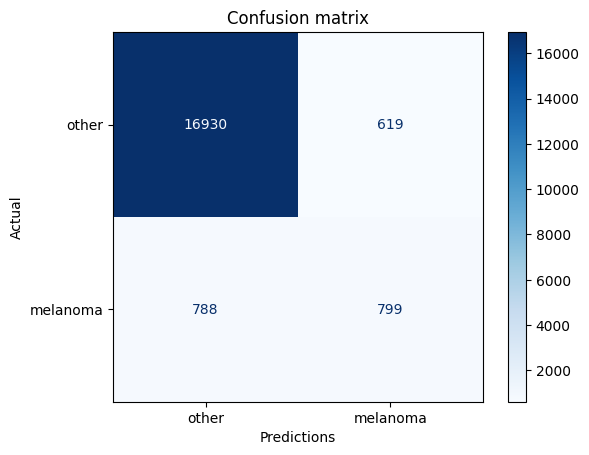

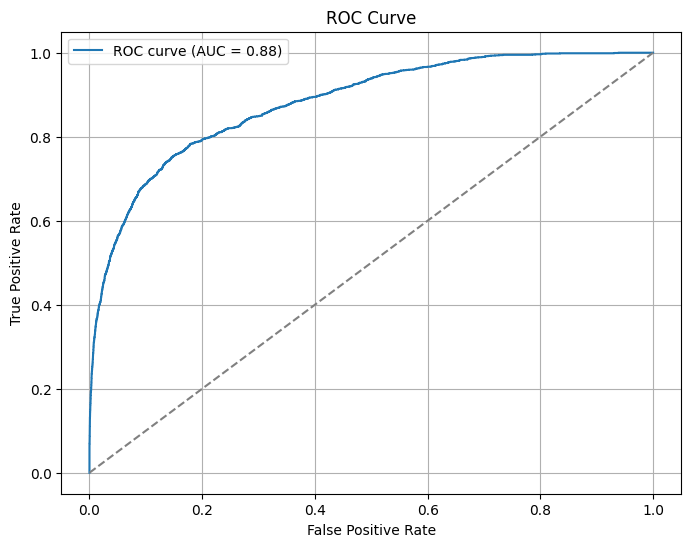

In [ ]:
predictions_df2 = ModelPredicting(test_dataset, ft_model, model_name=MODEL_NAME)

### оцінка на очищених даних

In [ ]:
# обробка тестових даних
test_data_dir = pathlib.Path('/content/full_ds_croppedtr_no_augm/test')
prepocess_to_crop(test_data_dir, center_ratio=0.5, threshold=70)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

With vignette /content/full_ds_croppedtr_no_augm/test/other: 2028
Without vignette /content/full_ds_croppedtr_no_augm/test/other: 15521
17549
With vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 517
Without vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 1070
1587
Found 19136 files belonging to 2 classes.


In [ ]:
# https://drive.google.com/file/d/1w9vCnxTaL8rbY5UJFWSpFKfLFpfEhppo/view?usp=sharing
file_id = "1w9vCnxTaL8rbY5UJFWSpFKfLFpfEhppo"
url = f"https://drive.google.com/uc?id={file_id}"
output = "ft-VIT-05-04-07.keras"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1w9vCnxTaL8rbY5UJFWSpFKfLFpfEhppo
From (redirected): https://drive.google.com/uc?id=1w9vCnxTaL8rbY5UJFWSpFKfLFpfEhppo&confirm=t&uuid=bd49ed0f-f68d-4632-a87e-8b457f0ce678
To: /content/ft-VIT-05-04-07.keras
100%|██████████| 1.04G/1.04G [00:11<00:00, 89.9MB/s]


'ft-VIT-05-04-07.keras'

In [ ]:
MODEL_NAME = 'ft-VIT-05-04-07'

model_path2 = '/content/ft-VIT-05-04-07.keras'
ft_model = keras.models.load_model(model_path2, custom_objects=custom_objects)

In [ ]:
# оцінка на оброблених даних

ModelEvaluating(test_ds,
                ft_model, model_name='VIT-05-04-07',
                metrics=METRICS)


598/598 [==============================] - 262s 437ms/step - loss: 0.2436 - accuracy: 0.9251 - precision: 0.5493 - recall: 0.5406 - tp: 858.0000 - fp: 704.0000 - tn: 16845.0000 - fn: 729.0000 - auc: 0.8720 - prc: 0.5655
loss :  0.24359740316867828
accuracy :  0.9251149892807007
precision :  0.5492957830429077
recall :  0.5406427383422852
tp :  858.0
fp :  704.0
tn :  16845.0
fn :  729.0
auc :  0.8720172643661499
prc :  0.5654821395874023
f1_beta :  0.5423514685549428


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0.24359740316867828,
 0.9251149892807007,
 0.5492957830429077,
 0.5406427383422852,
 858.0,
 704.0,
 16845.0,
 729.0,
 0.8720172643661499,
 0.5654821395874023,
 0.5423514685549428]

Found 19136 files belonging to 1 classes.
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17549
           1       0.55      0.54      0.54      1587

    accuracy                           0.93     19136
   macro avg       0.75      0.75      0.75     19136
weighted avg       0.92      0.93      0.92     19136

(0.9245803426905156, 0.925114966555184, 0.9250059419702747, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

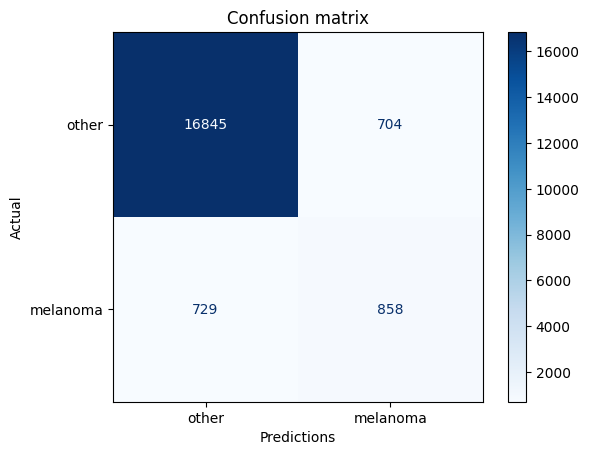

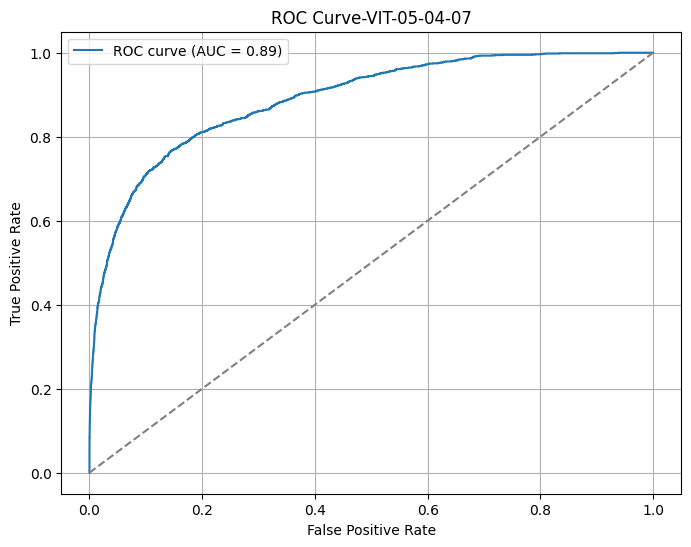

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=(256, 256),
  batch_size=BATCH_SIZE,
  shuffle=False)

prediction_df = ModelPredicting(test_dataset, ft_model, model_name='VIT-05-04-07')

### change batch_size and lr

In [ ]:
model_path = '/content/ft-VIT-05-04-07.keras'
ft_model = keras.models.load_model(model_path, custom_objects=custom_objects)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
MODEL_NAME = 'ft-VIT-05-04-07'
IM_SIZE = 256
BATCH_SIZE = 32
# VERSION = generate_model_version_name()
LEARNING_RATE = 1e-5

In [ ]:
ft_model.trainable = True

!redefine dataset

In [ ]:
base_model = TFViTModel.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_brain_tumor_diagnosis")
print(base_model.config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

OSError: DunnBC22/vit-base-patch16-224-in21k_brain_tumor_diagnosis does not appear to have a file named tf_model.h5 but there is a file for PyTorch weights. Use `from_pt=True` to load this model from those weights.

In [ ]:
for layer in ft_model.layers:
    print(layer.name)

input_1
resize_rescale_for_HF_VIT
tf_vi_t_model
extract_cls_token
dense
dropout_37
pred


In [ ]:
base_model = ft_model.get_layer("tf_vi_t_model")
for i, layer in enumerate(base_model.layers):
  print(f'{i+1}. {layer.name}: {layer.output.shape}')

AttributeError: Layer vit has no inbound nodes.

In [ ]:
# filepath for second checkpoint of best metric
filepath = f'/content/{MODEL_NAME}_2_best_metric.keras'

# AdamW через TensorFlow

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=3970,
    decay_rate=0.95
)

optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule, weight_decay=0.01)

custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')
callbacks_list = [EarlyStopping(monitor='val_auc', patience=2),
                  ModelCheckpoint(f'{MODEL_NAME}_2.keras', monitor='val_loss', save_best_only=True),
                  custom_checkpoint]

epochs=5

In [ ]:
# from models_processing_utils import ModelTraining

ft-VIT-05-04-07
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 resize_rescale_for_HF_VIT   (None, 3, 224, 224)       0         Y          
 (Sequential)                                                               
                                                                            
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPo   8638924   Y          
                             oling(last_hidden_state   8                    
                             =(None, 197, 768),                             
                              pooler_output=(None, 7                        
                             68),                                           
                              hidden_states=N

3970/3970 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9555 - precision: 0.8378 - recall: 0.9541 - tp: 31621.0000 - fp: 6123.0000 - tn: 132483.0000 - fn: 1521.0000 - auc: 0.9920 - prc: 0.9740

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



 Model saved on epoch 1 (val_auc: 0.9113)
3970/3970 [==============================] - 5091s 1s/step - loss: 0.1033 - accuracy: 0.9555 - precision: 0.8378 - recall: 0.9541 - tp: 31621.0000 - fp: 6123.0000 - tn: 132483.0000 - fn: 1521.0000 - auc: 0.9920 - prc: 0.9740 - val_loss: 0.5934 - val_accuracy: 0.8437 - val_precision: 0.9247 - val_recall: 0.6513 - val_tp: 663.0000 - val_fp: 54.0000 - val_tn: 1545.0000 - val_fn: 355.0000 - val_auc: 0.9113 - val_prc: 0.8998
Epoch 2/5
3970/3970 [==============================] - 5013s 1s/step - loss: 0.0734 - accuracy: 0.9725 - precision: 0.8922 - recall: 0.9750 - tp: 23838.0000 - fp: 2881.0000 - tn: 99681.0000 - fn: 612.0000 - auc: 0.9962 - prc: 0.9863 - val_loss: 0.7703 - val_accuracy: 0.8410 - val_precision: 0.9375 - val_recall: 0.6336 - val_tp: 645.0000 - val_fp: 43.0000 - val_tn: 1556.0000 - val_fn: 373.0000 - val_auc: 0.8825 - val_prc: 0.8819
Epoch 3/5
3970/3970 [==============================] - 5015s 1s/step - loss: 0.0482 - accuracy: 0.982

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

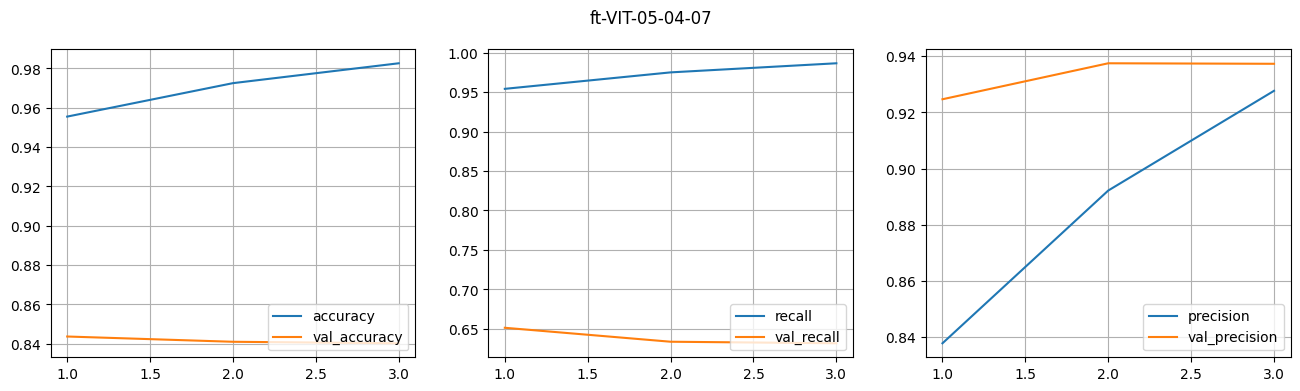

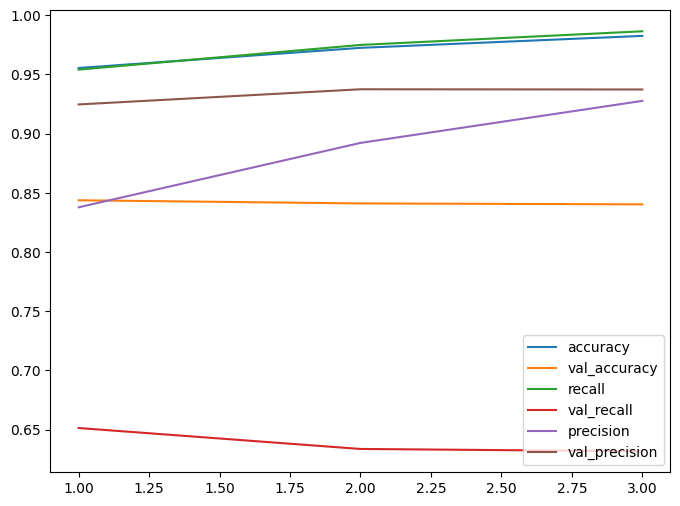

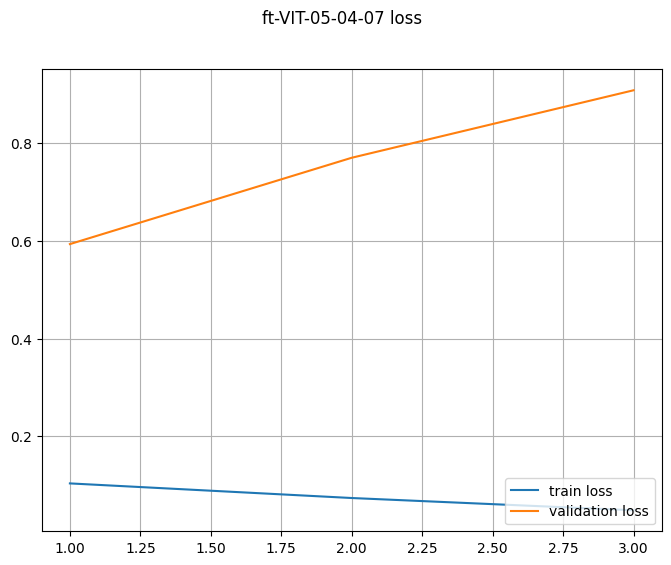

(<tf_keras.src.engine.functional.Functional at 0x7a50e00cdb90>,
        loss  accuracy  precision    recall       tp      fp        tn      fn  \
 0  0.103288  0.955493   0.837776  0.954107  31621.0  6123.0  132483.0  1521.0   
 1  0.073358  0.972499   0.892174  0.974969  23838.0  2881.0   99681.0   612.0   
 2  0.048248  0.982600   0.927692  0.986503  24120.0  1880.0  100682.0   330.0   
 
         auc       prc  val_loss  val_accuracy  val_precision  val_recall  \
 0  0.991981  0.974027  0.593426      0.843714       0.924686    0.651277   
 1  0.996247  0.986333  0.770261      0.841039       0.937500    0.633595   
 2  0.997963  0.991624  0.908462      0.840275       0.937318    0.631631   
 
    val_tp  val_fp  val_tn  val_fn   val_auc   val_prc  
 0   663.0    54.0  1545.0   355.0  0.911260  0.899834  
 1   645.0    43.0  1556.0   373.0  0.882549  0.881857  
 2   643.0    43.0  1556.0   375.0  0.862960  0.858318  )

In [ ]:
ModelTraining(train_ds, val_ds,
              ft_model, model_name=MODEL_NAME, optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS, output_bias=None,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)

Оцінка на очищених даних

In [ ]:
# https://drive.google.com/file/d/1qdkpgIHGO_4Zo_ZHWTOo-M7ib4f2p_Ze/view?usp=sharing
file_id = "1qdkpgIHGO_4Zo_ZHWTOo-M7ib4f2p_Ze"
url = f"https://drive.google.com/uc?id={file_id}"
output = "ft-VIT-05-04-07_2.keras"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1qdkpgIHGO_4Zo_ZHWTOo-M7ib4f2p_Ze
From (redirected): https://drive.google.com/uc?id=1qdkpgIHGO_4Zo_ZHWTOo-M7ib4f2p_Ze&confirm=t&uuid=b98dc9b3-97f9-4e91-bbc9-1421810e62a3
To: /content/tl-VIT-05-04-07_2.keras
100%|██████████| 1.04G/1.04G [00:13<00:00, 74.4MB/s]


'tl-VIT-05-04-07_2.keras'

In [ ]:
model_path2 = '/content/ft-VIT-05-04-07_2.keras'
ft_model = keras.models.load_model(model_path2, custom_objects=custom_objects)
# оцінка на оброблених даних

ModelEvaluating(test_ds,
                ft_model, model_name='VIT-05-04-07',
                metrics=METRICS)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


598/598 [==============================] - 263s 427ms/step - loss: 0.3161 - accuracy: 0.9270 - precision: 0.5656 - recall: 0.5186 - tp: 823.0000 - fp: 632.0000 - tn: 16917.0000 - fn: 764.0000 - auc: 0.8401 - prc: 0.5214
loss :  0.31605151295661926
accuracy :  0.9270485043525696
precision :  0.5656357407569885
recall :  0.5185885429382324
tp :  823.0
fp :  632.0
tn :  16917.0
fn :  764.0
auc :  0.8400745987892151
prc :  0.5214002132415771
f1_beta :  0.5273612808378304


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0.31605151295661926,
 0.9270485043525696,
 0.5656357407569885,
 0.5185885429382324,
 823.0,
 632.0,
 16917.0,
 764.0,
 0.8400745987892151,
 0.5214002132415771,
 0.5273612808378304]

Found 19136 files belonging to 1 classes.
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17549
           1       0.57      0.52      0.54      1587

    accuracy                           0.93     19136
   macro avg       0.76      0.74      0.75     19136
weighted avg       0.92      0.93      0.93     19136

(0.9243503170627968, 0.9270484949832776, 0.9264481249942541, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

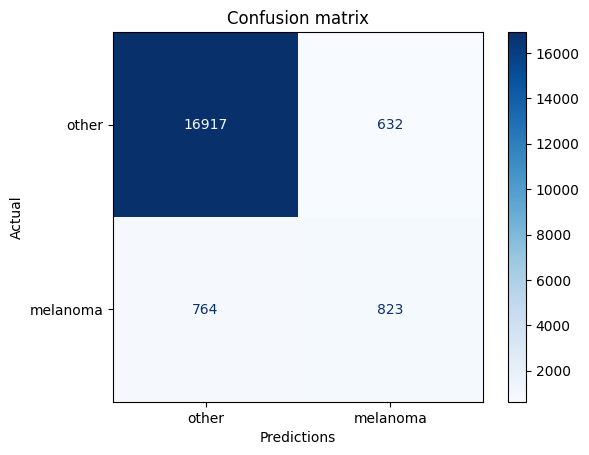

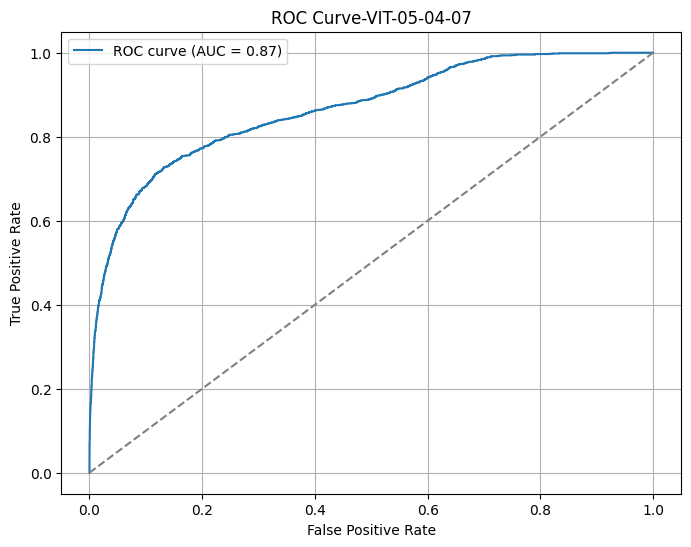

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=(256, 256),
  batch_size=BATCH_SIZE,
  shuffle=False)

prediction_df = ModelPredicting(test_dataset, ft_model, model_name='VIT-05-04-07')